### Building the Image Dataset

The following python code will use the OS library to use Operating System libraries, giving you access to the file system, and the zipfile library allowing you to unzip the data. 

<a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [27]:
import os

!git clone https://github.com/PramukaWeerasinghe/Abdomial_Image_Classification

Cloning into 'Abdomial_Image_Classification'...
remote: Enumerating objects: 233, done.
remote: Counting objects: 100% (233/233), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 233 (delta 66), reused 231 (delta 64), pack-reused 0
Receiving objects: 100% (233/233), 152.12 KiB | 6.91 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [29]:
# Directory with our training dandelion pictures
train_aorta_dir = '/content/Abdomial_Image_Classification/train/aorta/'

# Directory with our training grass pictures
train_nonaorta_dir = '/content/Abdomial_Image_Classification/train/nonaorta/'

# Directory with our validation dandelion pictures
valid_aorta_dir = '/content/Abdomial_Image_Classification/valid/aorta/'

# Directory with our validation grass pictures
valid_nonaorta_dir = '/content/Abdomial_Image_Classification/valid/nonaorta/'

Now, let's see what the filenames look like in the `aorta` and `non-aorta` training directories:

In [30]:
train_aorta_names = os.listdir(train_aorta_dir)
print(train_aorta_names[:10])

train_nonaorta_names = os.listdir(train_nonaorta_dir)
print(train_nonaorta_names[:10])

validation_aorta_names = os.listdir(valid_aorta_dir)
print(validation_aorta_names[:10])

validation_nonaorta_names = os.listdir(valid_nonaorta_dir)
print(validation_nonaorta_names[:10])

['A9230.jpg', 'KKC415.jpg', 'PER173.jpg', 'A9235.jpg', 'AA33125.jpg', 'MLD135.jpg', 'AA33140.jpg', 'MBE215.jpg', 'JA205.jpg', 'JA185.jpg']
['non_aorta_24.jpg', 'non_aorta_17.jpg', 'non_aorta_76.jpg', 'non_aorta_38.jpg', 'non_aorta_13.jpg', 'non_aorta_78.jpg', 'non_aorta_39.jpg', 'non_aorta_36.jpg', 'non_aorta_2.jpg', 'non_aorta_34.jpg']
['X24140.jpg', 'X23155.jpg', 'X17195.jpg', 'X23160.jpg', 'X17205.jpg', 'X25145.jpg', 'X20195.jpg', 'X20205.jpg', 'X23165.jpg', 'X24135.jpg']
['not_nicolas_6.jpg', 'not_nicolas_17.jpg', 'not_nicolas_10.jpg', 'not_nicolas_1.jpg', 'not_nicolas_24.jpg', 'not_nicolas_21.jpg', 'not_nicolas_5.jpg', 'not_nicolas_12.jpg', 'not_nicolas_3.jpg', 'non_aorta_97.jpg']


Let's find out the total number of dandelion and grass images in the directories:

In [31]:
print('total training aorta images:', len(os.listdir(train_aorta_dir)))
print('total training nonaorta images:', len(os.listdir(train_nonaorta_dir)))
print('total validation aorta images:', len(os.listdir(valid_aorta_dir)))
print('total validation nonaorta images:', len(os.listdir(valid_nonaorta_dir)))

total training aorta images: 70
total training nonaorta images: 90
total validation aorta images: 30
total validation nonaorta images: 35


Now let's take a look at a few pictures to get a better sense of what they look like. First, configure the matplot parameters:

In [32]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

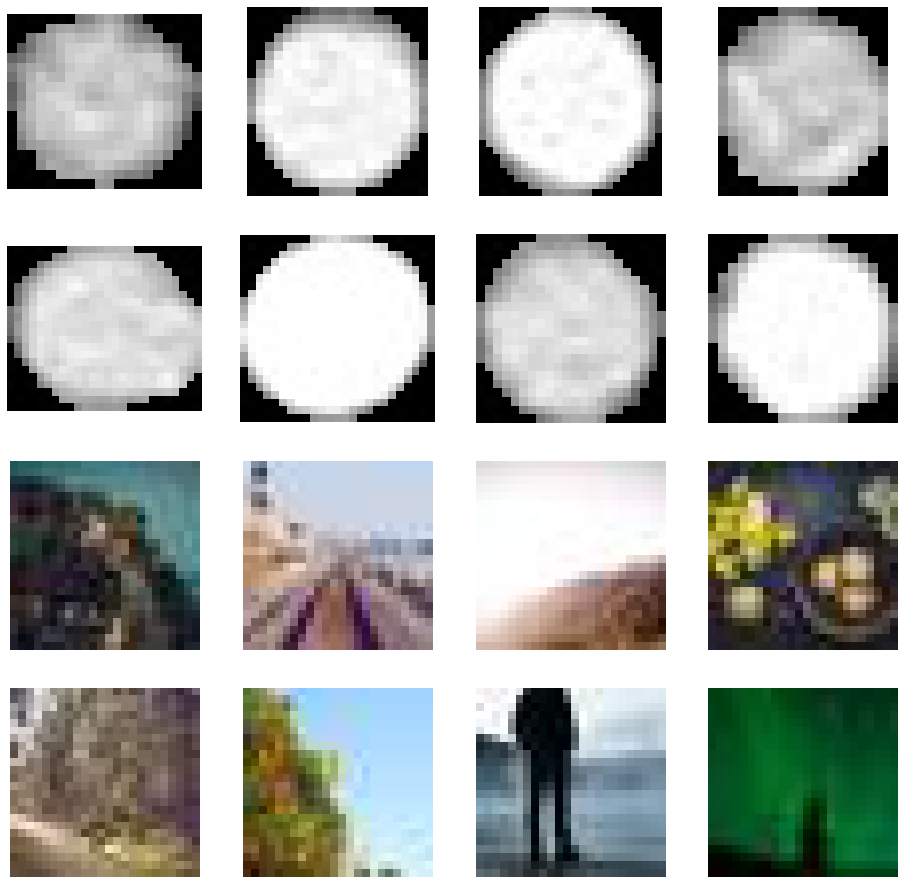

In [33]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_aorta_pic = [os.path.join(train_aorta_dir, fname) 
                for fname in train_aorta_names[pic_index-8:pic_index]]
next_nonaorta_pic = [os.path.join(train_nonaorta_dir, fname) 
                for fname in train_nonaorta_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_aorta_pic + next_nonaorta_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


#### Data Preprocessing

Now, let's use `keras.preprocessing.image.ImageDataGenerator` class to create our train and validation dataset and normalize our data. 

It's important to normalize our data because data going into our CNN to improve its overall performance. We will use the `rescale` parameter to scale our image pixel values from [0, 255] to [0,1].

In each generator, we specify the source directory of our images, the classes, the input image size, the batch size (how many images to process at once), and class mode.

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 120 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/Abdomial_Image_Classification/train/',  # This is the source directory for training images
        classes = ['aorta', 'nonaorta'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=5,
        # Use binary labels
        class_mode='binary')

# Flow validation images in batches of 19 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/content/Abdomial_Image_Classification/valid/',  # This is the source directory for training images
        classes = ['aorta', 'nonaorta'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=3,
        # Use binary labels
        class_mode='binary',
        shuffle=False)

Found 160 images belonging to 2 classes.
Found 65 images belonging to 2 classes.


## Building the Model from Scratch

But before we continue, let's start defining the model:

Step 1 will be to import tensorflow.

In [43]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

Let's then add a Flatten layer that flattens the input image, which then feeds into the next layer, a Dense layer, or fully-connected layer, with 128 hidden units. Finally, because our goal is to perform binary classification, our final layer will be a sigmoid, so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is of class 1 (class 1 being grass and class 0 being dandelion).

In [44]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (200,200,3)), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

The model.summary() method call prints a summary of the NN 

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 120000)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               15360128  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 15,360,257
Trainable params: 15,360,257
Non-trainable params: 0
_________________________________________________________________


The "output shape" column shows the transformation of the dimensions of each layer as a result of the convolution and max pooling - convolution will reduce the layer size by a bit due to padding, and max pooling will halve the output size.

Next, we'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss. We will use the `Adam` optimizer. [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) is a sensible optimization algorithm because it automates learning-rate tuning for us (alternatively, we could also use [RMSProp](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) or [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad) for similar results). We will add accuracy to `metrics` so that the model will monitor accuracy during training

In [46]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

### Training
Let's train for 15 epochs.

Note that steps_per_epoch was set along with batch_size in ImageDataGenerator so that steps_per_epoch * batch_size = total # of images. For example, for training, 8 * 120 = 960, just under our total of 999 images.

Notice that as we train, our validation accuracy never exceeds training accuracy, which is a good thing. Our model won't work better on unseen images than seen images.

In [47]:
# history = model.fit(
#       train_generator,
#       steps_per_epoch=8,  
#       epochs=15,
#       verbose=1,
#       validation_data = validation_generator,
#       validation_steps=8)

history = model.fit(train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/15
8/8 [==============================] - 1s 78ms/step - loss: 9.8660 - accuracy: 0.8000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/15
8/8 [==============================] - 1s 68ms/step - loss: 1.5606 - accuracy: 0.9250 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/15
8/8 [==============================] - 1s 70ms/step - loss: 1.8775e-12 - accuracy: 1.0000 - val_loss: 4.0957 - val_accuracy: 0.7500
Epoch 4/15
8/8 [==============================] - 1s 67ms/step - loss: 1.2142 - accuracy: 0.9250 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/15
8/8 [==============================] - 1s 67ms/step - loss: 1.3341 - accuracy: 0.9750 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/15
8/8 [==============================] - 1s 67ms/step - loss: 0.6202 - accuracy: 0.9750 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/15
8/8 [==============================] - 1s 70ms/step - loss: 2.1137 - accuracy: 0.9750 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

## Accuracy, ROC Curve, and AUC

Let's evaluate the accuracy of our model:

In [48]:
model.evaluate(validation_generator)

22/22 [==============================] - 0s 10ms/step - loss: 2.7101e-34 - accuracy: 1.0000


[2.7100967156910144e-34, 1.0]

Now, let's calculate our ROC curve and plot it.

First, let's make predictions on our validation set. When using generators to make predictions, we must first turn off shuffle (as we did when we created validation_generator) and reset the generator:

In [49]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
                      verbose=1)

22/22 [==============================] - 0s 9ms/step


To create the ROC curve and AUC, we'll need to compute the false-positive rate and the true-positive rate:

In [50]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)

In [51]:
roc_auc = auc(fpr, tpr)

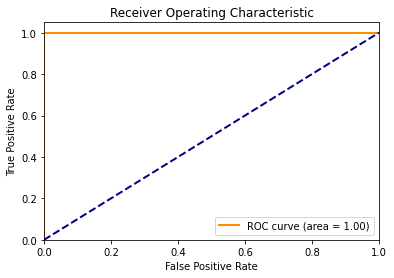

In [52]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The ROC curve is a probability curve plotting the true-positive rate (TPR) against the false-positive rate (FPR). In this curve, the diagonal line is the curve for random guessing, e.g. coin flipping, so the ROC curve above shows that our model does better than chance at classifying between dandelions and grass. Not bad!

Similarly, the AUC (area under curve), as shown in the legend above, measures how much our model is capable of distinguishing between our two classes, dandelions and grass. The higher the AUC, the better our model is at classification. It is also used to compare different models, which I will do in future tutorials when I present how to build an image classifier using Convolutional Neural Networks and transfer learning with ResNet!

## Making Predictions

Now, let's use the model to make predictions! Upload an image to see if it's a dandelion or grass.

Saving A9230.jpg to A9230 (1).jpg
[0.]
A9230.jpg is a aorta


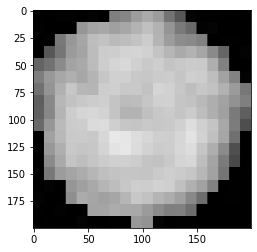

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(200, 200))
  x = image.img_to_array(img)
  plt.imshow(x/255.)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]<0.5:
    print(fn + " is a aorta")
  else:
    print(fn + " is a nonaorta")
 